In [1]:
from pathlib import Path

from torch.nn.init import zeros_

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/orenri/Projects/pyERGM


/Users/orenri/Projects/pyERGM/venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pyERGM.utils import *
from pyERGM.ergm import ERGM
from pyERGM.metrics import *
from pyERGM.datasets import sampson_matrix

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

/Users/orenri/Projects/pyERGM/pyERGM/metrics.py:508: SyntaxWarning: invalid escape sequence '\c'
  """


In [3]:
n = sampson_matrix.shape[0]

In [4]:
is_directed = True
metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree(), TotalReciprocity()]
model = ERGM(n, metrics, is_directed=is_directed)

Collinearity detected, identifying features to remove
Removing the 0 feature of outdegree
Collinearity detected, identifying features to remove
Removing the 0 feature of indegree


In [5]:
change_scores = np.zeros(((n ** 2 - n) // 2, 4, model._metrics_collection.calc_num_of_features()))
idx = 0
zeros_net = np.zeros((n, n))
for i in range(n - 1):
    for j in range(i + 1, n):
        change_score_i_j = model._metrics_collection.calc_change_scores(zeros_net, {'edge': (i, j)})
        net_with_i_j = zeros_net.copy()
        net_with_i_j[i, j] = 1
        change_scores[idx, 1] = change_score_i_j
        change_score_j_i = model._metrics_collection.calc_change_scores(zeros_net, {'edge': (j, i)})
        change_scores[idx, 2] = change_score_j_i
        change_score_j_i_after_i_= model._metrics_collection.calc_change_scores(net_with_i_j, {'edge': (j, i)})
        change_scores[idx, 3] = change_score_j_i_after_i_ + change_score_i_j
        idx += 1

In [9]:
change_scores[0, 3]

array([2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

In [10]:
y = np.zeros(((n ** 2 - n) // 2, 4))
idx = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        if not sampson_matrix[i, j] and not sampson_matrix[j, i]:
            y[idx, 0] = 1
        elif sampson_matrix[i, j] and not sampson_matrix[j, i]:
            y[idx, 1] = 1
        elif not sampson_matrix[i, j] and sampson_matrix[j, i]:
            y[idx, 2] = 1
        else:
            y[idx, 3] = 1
        idx += 1

In [11]:
from scipy.special import softmax


def predict(Xs, thetas):
    return softmax(Xs @ thetas, axis=1)


def minus_log_likelihood(thetas, Xs, ys):
    return -np.log(predict(Xs, thetas)[np.where(ys == 1)]).sum()

def minus_log_likelihood_gradient(thetas, Xs, ys):
    prediction = predict(Xs, thetas)
    num_features = Xs.shape[-1]
    return -(ys - prediction).flatten() @ Xs.reshape(-1, num_features)
    
        

In [14]:
from scipy.optimize import minimize
def after_iteration_callback(intermediate_result: OptimizeResult):
    cur_time = time.time()
    print(f'training: {cur_time - start_time} '
          f'log10 likelihood: {-intermediate_result.fun / np.log(10)}')
    sys.stdout.flush()


thetas = np.random.rand(model._metrics_collection.calc_num_of_features())
start_time = time.time()
res = minimize(minus_log_likelihood, thetas, args=(change_scores, y), 
                           jac=minus_log_likelihood_gradient, method="L-BFGS-B", callback=after_iteration_callback)

training: 0.0013208389282226562 log10 likelihood: -134.59981986824778
training: 0.0028319358825683594 log10 likelihood: -87.99261930789979
training: 0.003683805465698242 log10 likelihood: -79.82962997621102
training: 0.004630088806152344 log10 likelihood: -76.76087879841505
training: 0.0055789947509765625 log10 likelihood: -74.7444354422664
training: 0.006635904312133789 log10 likelihood: -65.77269919059701
training: 0.0075130462646484375 log10 likelihood: -64.6682776601011
training: 0.008444786071777344 log10 likelihood: -62.99361400731236
training: 0.009636878967285156 log10 likelihood: -62.36066596079582
training: 0.01034092903137207 log10 likelihood: -62.08403490670974
training: 0.011066913604736328 log10 likelihood: -61.918965990502
training: 0.012036800384521484 log10 likelihood: -61.49855966821792
training: 0.012695074081420898 log10 likelihood: -61.15317579841764
training: 0.013209819793701172 log10 likelihood: -61.08372123708604
training: 0.013799905776977539 log10 likelihood:

In [15]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 139.70220174655364
        x: [-1.192e+00 -2.300e-01 ... -3.308e+00  3.700e+00]
      nit: 31
      jac: [ 3.227e-04  3.439e-04 ...  8.856e-05  2.578e-04]
     nfev: 35
     njev: 35
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>

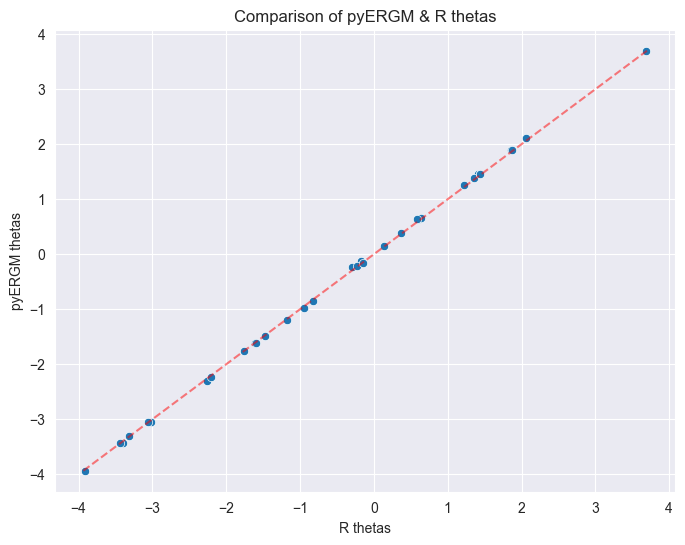

In [16]:
import seaborn as sns

true_values = {"edges": -1.1761, "sender2": -0.2945, "sender3": 1.4141, "sender4": 0.3662, "sender5": 0.1315,
               "sender6": 1.2148, "sender7": 0.6055,
               "sender8": 1.3609, "sender9": 0.6402, "sender10": 2.0639, "sender11": 1.4355, "sender12": -0.1681,
               "sender13": -0.2322, "sender14": 0.5841, "sender15": 1.8600,
               "sender16": 1.4317, "sender17": 1.2211, "sender18": 1.8724, "receiver2": -0.1522, "receiver3": -3.0453,
               "receiver4": -1.7596, "receiver5": -0.8198, "receiver6": -3.3922,
               "receiver7": -1.6074, "receiver8": -2.2656, "receiver9": -2.2069, "receiver10": -3.9189,
               "receiver11": -3.0257, "receiver12": -0.9457, "receiver13": -1.4749, "receiver14": -1.5950,
               "receiver15": -3.3147, "receiver16": -3.0567, "receiver17": -3.4436, "receiver18": -3.3239,
               "mutual": 3.6918
               }

true_thetas = np.array(list(true_values.values()))

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=true_thetas, y=res.x)

min_x = min(min(true_thetas), min(res.x))
max_x = max(max(true_thetas), max(res.x))

sns.lineplot(x=[min_x, max_x], y=[min_x, max_x], color="red", linestyle="--", alpha=0.5)
ax.set(xlabel='R thetas', ylabel='pyERGM thetas')
ax.set_title("Comparison of pyERGM & R thetas")
plt.show()
